# Analysis of human and model behavior across physical domains

**The purpose of this notebook is to:** 
* Apply preprocessing to human behavioral data
* Visualize distribution and compute summary statistics over **human** physical judgments
* Visualize distribution and compute summary statistics over **model** physical judgments
* Conduct human-model comparisons
* Output CSV that can be re-loaded into R notebook for statistical modeling & fancy visualizations

**This notebook depends on:**
* Running `./generate_dataframes.py` (INTERNAL USE ONLY)
* Running `./upload_results.py` (INTERNAL USE ONLY)
* Running `./download_results.py` (PUBLIC USE)

## setup

#### Load packages

In [1]:
import os
import sys
import urllib, io

sys.path.append('./analysis_helpers')
from importlib import reload

import numpy as np
import scipy.stats as stats
import pandas as pd

import analysis_helpers as h

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

from tqdm.notebook import tqdm

import  matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('seaborn-white')

import seaborn as sns

%matplotlib inline
import scipy.stats
import sklearn.metrics
import random

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

#### options

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# seaborn plotting themes
sns.set_context('talk')
sns.set_style("whitegrid")

#### set up paths and directories

In [3]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
## add helpers to python path
if os.path.join(analysis_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(analysis_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

### load human data

In [4]:
from experiment_meta import *
HEM = pd.DataFrame(NEURIPS2021_EXPS) # HEM = "human experiment metadata"
HEM

,study,bucket_name,stim_version,iterationName
0,dominoes_pilot,human-physics-benchmarking-dominoes-pilot,production_1,production_1_testing
1,collision_pilot,human-physics-benchmarking-collision-pilot,production_2,production_2_testing
2,towers_pilot,human-physics-benchmarking-towers-pilot,production_2,production_2_testing
3,linking_pilot,human-physics-benchmarking-linking-pilot,production_2,production_2_testing
4,containment_pilot,human-physics-benchmarking-containment-pilot,production_2,production_2_testing
5,rollingsliding_pilot,human-physics-benchmarking-rollingsliding-pilot,production_2,production_2_testing
6,drop_pilot,human-physics-benchmarking-drop-pilot,production_2,production_2_testing
7,clothiness_pilot,human-physics-benchmarking-clothiness-pilot,production_2,production_2_testing


In [5]:
SCENARIOS = sorted([n.split("_")[0] for n in HEM['study'].unique()])

In [6]:
## get paths to all human response data
data_paths = [os.path.join(csv_dir,'humans',i) for i in os.listdir(os.path.join(csv_dir,'humans'))]
resp_paths = [i for i in data_paths if i.split('/')[-1].split('-')[0]=='human_responses']
assert len(resp_paths)==8

In [7]:
## also load all human data into a big dataframe
HD = pd.concat([h.load_and_preprocess_data(p) for p in resp_paths])
print("Loaded {} lines".format(len(HD)))

Loaded 120450 lines


### load model data

In [8]:
## get paths to all model data
model_data_paths = [os.path.join(csv_dir,'models',i) for i in os.listdir(os.path.join(csv_dir,'models'))]
model_res_paths = [i for i in model_data_paths if i.split('.')[-1] == "csv"]

In [9]:
## load all model results into a single dataframe
MD = pd.concat([pd.read_csv(p).assign(filename=p.split('/')[-1]) for p in model_res_paths])
print("Loaded {} rows".format(len(MD)))

Loaded 115698 rows


/Users/felixbinder/anaconda3/envs/tdw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
# a couple of import steps (restore original scenario names, add single prediction value, add correctness column)
MD = h.process_model_dataframe(MD)

In [11]:
#check for duplicated rows
if len(MD.duplicated()) > 0:
    print("⚠️There are {} duplicated rows!".format(np.sum(MD.duplicated())))
    MD = MD[~MD.duplicated(h.MODEL_COLS+["Stimulus Name"],keep="first")]
    print("Removed duplicates, {} rows left".format(len(MD)))

⚠️There are 18422 duplicated rows!
Removed duplicates, 83664 rows left


### generate summary table of human 95% CIs for accuracy across all scenarios

In [12]:
## init human_bootstrapped_accuracy for plotting
human_bootstrapped_accuracy = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)
    
    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)

    ## compute bootstrapped sampling distributions of accuracy
    Dacc = D.groupby('prolificIDAnon').agg({'correct':np.mean})
    bootmeans = h.bootstrap_mean(Dacc, col='correct', nIter=1000)

    obsmean = np.mean(Dacc.correct.values)
    bootmean = np.mean(bootmeans)
    lb = np.percentile(bootmeans,2.5)
    ub = np.percentile(bootmeans,97.5)
    pct25 = np.percentile(Dacc,2.5)
    pct975 = np.percentile(Dacc,97.5)
    ## merge bootstrapped accuracy estimates
    if len(human_bootstrapped_accuracy)==0:
        human_bootstrapped_accuracy = pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()
    else:
        human_bootstrapped_accuracy = pd.concat([human_bootstrapped_accuracy, pd.DataFrame(['human', scenarioName, obsmean,bootmean,lb,ub, pct25, pct975]).transpose()],axis=0)
        
## add column names        
human_bootstrapped_accuracy.columns=['agent','scenario','obs_mean', 'boot_mean', 'ci_lb', 'ci_ub', 'pct_2.5', 'pct_97.5']

## save out human_bootstrapped_accuracy to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_bootstrapped_accuracy.to_csv(os.path.join(csv_dir, 'summary','human_accuracy_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [13]:
human_bootstrapped_accuracy

,agent,scenario,obs_mean,boot_mean,ci_lb,ci_ub,pct_2.5,pct_97.5
0,human,collision,0.808511,0.808485,0.798793,0.81766,0.704333,0.88
0,human,rollingsliding,0.882986,0.882948,0.875411,0.890696,0.789167,0.94
0,human,dominoes,0.692791,0.6927,0.684341,0.701163,0.614167,0.76
0,human,drop,0.743656,0.743722,0.73541,0.751326,0.666667,0.804667
0,human,clothiness,0.678133,0.678222,0.663729,0.692269,0.543667,0.771667
0,human,linking,0.643182,0.643234,0.631968,0.654545,0.536833,0.744333
0,human,containment,0.766988,0.766892,0.758072,0.775026,0.686667,0.839667
0,human,towers,0.763137,0.763012,0.754975,0.770982,0.669333,0.826


### Human-human consistency across stimuli (within scenario)
We will analyze human-human consistency by computing the mean correlation between (binary) response vectors produced by each human participant across all stimuli within each scenario. 



#### Correlation

In [14]:
## init human_boot_corr for plotting
human_boot_corr = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
    
    ## get pairwise correlations
    dists = 1-scipy.spatial.distance.pdist(respMat, metric='correlation')
    corrMat = scipy.spatial.distance.squareform(dists)
    
    ## get percentiles over pairwise corrs
    pairwiseCorrs = corrMat[np.triu_indices(n=len(corrMat), k=1)]
    lb = np.percentile(pairwiseCorrs, 2.5)
    med = np.percentile(pairwiseCorrs, 50)
    ub = np.percentile(pairwiseCorrs, 97.5)  
        
    if len(human_boot_corr)==0:
        human_boot_corr = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_corr = pd.concat([human_boot_corr, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_corr.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_corr to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_corr.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCorrs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [15]:
human_boot_corr

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.388046,0.62822,0.776057
0,human,rollingsliding,0.506253,0.713836,0.851243
0,human,dominoes,0.231102,0.425943,0.591814
0,human,drop,0.266334,0.501544,0.681139
0,human,clothiness,0.065426,0.349287,0.549326
0,human,linking,0.114636,0.386807,0.569892
0,human,containment,0.306122,0.559038,0.725013
0,human,towers,0.299731,0.565581,0.725722


#### Cohen's $\kappa$

In [16]:
## init human_boot_cohenk for plotting
human_boot_cohenk = pd.DataFrame()

for exp_ind, exp_name in enumerate(resp_paths):
    
    ## get path to response data
    path_to_data = resp_paths[exp_ind]

    ## load data and apply preprocessing
    _D = h.load_and_preprocess_data(path_to_data)
    scenarioName = _D.scenarioName.values[0]
    print('Currently analyzing the {} experiment.'.format(_D.scenarioName.values[0]))
    clear_output(wait=True)

    ## apply exclusion criteria
    D = h.apply_exclusion_criteria(_D)
    
    ## create response feature matrix (numSubs x numTrialsPerSub)
    D2 = D.sort_values(by=['prolificIDAnon','stim_ID']).reset_index(drop=True)
    numSubs = len(np.unique(D['prolificIDAnon'].values))
    numTrialsPerSub = int(len(D)/numSubs)
    respMat = np.reshape(D2['responseBool'].values, (numSubs,numTrialsPerSub)) 

    ## sanity check that the reshape operation happened correctly
    assert len([i for (i,j) in list(zip(respMat[0],D2[:150]['responseBool'].values)) if i!=j])==0    
      
    ## compute Cohen's kappa
    ## with a horrific double loop
    kappas = []
    for i in range(respMat.shape[0]): # for each participant
        for j in range(i+1,respMat.shape[0]): # compare to every participant after them
            assert i != j
            kappa = sklearn.metrics.cohen_kappa_score(respMat[i],respMat[j])
            kappas.append(kappa)
    
    ## get percentiles over pairwise corrs
    lb = np.percentile(kappas, 2.5)
    med = np.percentile(kappas, 50)
    ub = np.percentile(kappas, 97.5)  
        
    if len(human_boot_cohenk)==0:
        human_boot_cohenk = pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()
    else:
        human_boot_cohenk = pd.concat([human_boot_cohenk, pd.DataFrame(['human', scenarioName, lb, med, ub]).transpose()],axis=0)
        
## add column names        
human_boot_cohenk.columns=['agent','scenario','corr_lb', 'corr_med', 'corr_ub']

## save out human_boot_cohenk to re-plot in R
if not os.path.exists(os.path.join(csv_dir, 'summary')):
    os.makedirs(os.path.join(csv_dir, 'summary'))    
human_boot_cohenk.to_csv(os.path.join(csv_dir, 'summary','human_pairwiseCohensKs_by_scenario.csv'), index=False)
print('Saved to file! Done.')

Saved to file! Done.


In [17]:
human_boot_cohenk

,agent,scenario,corr_lb,corr_med,corr_ub
0,human,collision,0.381969,0.621826,0.773353
0,human,rollingsliding,0.490152,0.707031,0.85095
0,human,dominoes,0.210147,0.410819,0.585372
0,human,drop,0.260437,0.494367,0.678875
0,human,clothiness,0.062416,0.340571,0.542955
0,human,linking,0.109512,0.369462,0.560538
0,human,containment,0.284806,0.546667,0.719987
0,human,towers,0.285117,0.549918,0.720673


## Visualize distribution of model physical judgments, by domain

In [18]:
MD_by_model = MD.groupby(['filename','Readout Test Data','Model','Dynamics Training Dataset','Readout Type']).agg({'correct':'mean'})
MD_by_model

correct
filename              Readout Test Data Model Dynamics Training Dataset Readout Type          
dataframe-results.csv clothiness        CSWM  all                       A             0.690000
                                                                        B             0.540000
                                                                        C             0.505000
                                              clothiness                A             0.595000
                                                                        B             0.535000
...                                                                                        ...
per_example_svg.csv   towers            SVG   no_towers                 D             0.483333
                                              towers                    A             0.716667
                                                                        B             0.575000
                                                                        C             0.637500
                                                                        D             0.637500

[384 rows x 1 columns]

## Compute summary statistics over model physical judgments, by domain

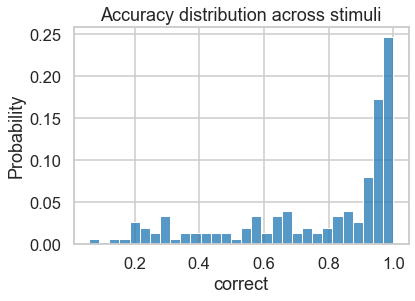

In [19]:
Dacc = D.groupby('stim_ID').agg({'correct':np.mean})
p = sns.histplot(data=Dacc, x='correct', bins=30, stat='probability')
t = plt.title('Accuracy distribution across stimuli')

## Conduct human-model comparisons
We will compare human and model behavior in two ways: **absolute performance** and **response pattern.**

#### **Absolute Performance** 
We will compare the accuracy of each model to the mean accuracy of humans, for each scenario. 
To do this, we will first compute estimates of mean human accuracy for each scenario and construct 95% confidence intervals for each of these estimates. 
These confidence intervals will be constructed by bootstrapping: specifically, for an experiment with N participants, we will resample N participants with replacement and compute the proportion correct for that bootstrapped sample. We will take repeat this resampling procedure 1000 times to generate a sampling distribution for the mean proportion correct. The 2.5th and 97.5th percentile will be extracted from this sampling distribution to provide the lower and upper bounds of the 95% confidence interval.

For each model, we will then compare their proportion correct (a point estimate) to the human confidence interval. 

In [20]:
# group model data by scenario
MD_by_scenario = MD.groupby(['Readout Test Data','ModelID']).agg(
        {**{ 'correct':'mean' },
         **{ col:'first' for col in h.MODEL_COLS} #save model identifying data as well
        })

In [21]:
accuracies = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD_by_scenario = MD_by_scenario.loc[[scenario]]
    for _,model_row in list(_MD_by_scenario.iterrows()):
        #each model is one row of MD
        human_row = human_bootstrapped_accuracy.query("scenario == @scenario")
#         assert len(model_row) == len(human_row) == 1
        correct_ratio = model_row['correct']/human_row['obs_mean']
        correct_diff = model_row['correct'] - human_row['obs_mean']
        accuracies[(scenario,model_row.name[1])] = {**{
                                                    'ratio': float(correct_ratio), 
                                                    'diff': float(correct_diff),
                                                    'human_correct': float(human_row['obs_mean']),
                                                    'model_correct': float(model_row['correct']),
                                                    },**{col: model_row[col] for col in h.MODEL_COLS}} # save information for model identification
    clear_output(wait=True)

model_human_accuracies = pd.DataFrame(accuracies).transpose()  
model_human_accuracies.to_csv(os.path.join(csv_dir, 'summary','model_human_accuracies.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [22]:
model_human_accuracies

ratio  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  1.017499   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.796304   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.744691   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  0.877409   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...   0.78893   
...                                                                 ...   
towers     SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_reado...   0.63335   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_A_t...  0.939106   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_B_t...  0.753469   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_C_t...  0.835367   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_D_t...  0.835367   

                                                                   diff  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  0.011867   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.138133   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti... -0.173133   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.083133   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co... -0.143133   
...                                                                 ...   
towers     SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_reado... -0.279804   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_A_t... -0.046471   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_B_t... -0.188137   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_C_t... -0.125637   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_D_t... -0.125637   

                                                              human_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.678133   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.678133   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...      0.678133   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.678133   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...      0.678133   
...                                                                     ...   
towers     SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_reado...      0.763137   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_A_t...      0.763137   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_B_t...      0.763137   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_C_t...      0.763137   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_D_t...      0.763137   

                                                              model_correct  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...          0.69   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...          0.54   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...         0.505   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...         0.595   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...         0.535   
...                                                                     ...   
towers     SVG_VGG_1.0_VAE_no_towers_VAE_1_no_towers_reado...      0.483333   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_A_t...      0.716667   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_B_t...         0.575   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_C_t...        0.6375   
           SVG_VGG_1.0_VAE_towers_VAE_1_towers_readout_D_t...        0.6375   

                                                              Model  \
clothiness CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  CSWM   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  CSWM   
           CSWM_CSWM encoder_0.0_Contrastive_all_Contrasti...  CSWM   
           CSWM_CSWM encoder_0.0_Contrastive_clothiness_Co...  CSWM   
           

#### **Response Pattern**
We will compare the pattern of predictions generated by each model to the pattern of predictions generated by humans. 

We will do this by using two standard inter-rater reliability metrics:
##### **Correlation**
For each pair of human participants, we will compute the correlation between their (binary) response vectors, yielding a distribution of pairwise human-human correlations. 
For each model, we will compute the correlation between its response vector and every human participant, as well as every other model. 
A model's response pattern will be considered more similar to humans' insofar as the mean model-human correlation (across humans) lies closer to the mean human-human correlation (for all pairs of humans).

In [61]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        if len(_MD_model) == 0: continue #we 
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute correlation
            measure = scipy.spatial.distance.correlation(model_responses,human_responses, centered=False)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                       'corr_lb':lb,
                                       'corr_med':med,
                                       'corr_ub':ub,
                                       'num_datapoints':len(measures_for_model)},
                                       **{col:_MD_model.head(1)[col].item() for col in h.MODEL_COLS} #save model ID info
                                      }
        clear_output(wait=True)

model_human_correlations = pd.DataFrame(out_dict).transpose()  
model_human_correlations.to_csv(os.path.join(csv_dir, 'summary','model_human_correlations.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [63]:
model_human_correlations

scenario  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...  clothiness   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   

                                                                corr_lb  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...    0.2252   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...    0.2252   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...    0.2252   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...    0.2252   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...    0.2252   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.249221   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.251955   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.227186   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.250967   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.252651   

                                                               corr_med  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.367544   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.367544   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.367544   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.367544   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...  0.367544   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.312881   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.320167   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.283629   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.309328   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.312652   

                                                                corr_ub  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.560748   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.560748   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.560748   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  0.560748   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...  0.560748   
...                                                                 ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...   0.38512   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...  0.387927   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.348704   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.381702   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...  0.377937   

                                                              num_datapoints  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D po

##### **Cohen's kappa**

In [52]:
out_dict = {}

for scenario in sorted(MD['Readout Test Data'].unique()):
    print("Now running scenario",scenario)
    _MD = MD[MD['Readout Test Data'] == scenario]
    _HD = HD[HD['scenarioName'] == scenario]
    for model in _MD['ModelID'].unique():
        measures_for_model = []
        #get responses of model        
        _MD_model = _MD[_MD['ModelID'] == model]
        _MD_model = _MD_model.sort_values('Canon Stimulus Name') #ensure same stim order
        #iterate over the 100 or so participants
        for gameID in _HD['gameID'].unique():
            #get one game
            _HD_game = _HD[_HD['gameID']==gameID]
            #ensure stim order
            _HD_game = _HD_game.sort_values('stim_ID')
            #in case the models have more or less responses compared to humans
            human_stim_names = list(_HD_game['stim_ID'])
            model_stim_names = list(_MD_model['Canon Stimulus Name'])
            joint_stim_names = set(human_stim_names).intersection(set(model_stim_names))
            if len(human_stim_names) > len(joint_stim_names):
                print("⚠️ {} is missing {} datapoints on {} human responses".format(model,len(human_stim_names) - len(joint_stim_names), len(human_stim_names)))
            #subset both models to ensure only common stims are used
            _MD_model = _MD_model[_MD_model['Canon Stimulus Name'].isin(joint_stim_names)]            
            _HD_game = _HD_game[_HD_game['stim_ID'].isin(joint_stim_names)]
            #pull response vector
            human_responses = np.array(_HD_game['responseBool'].astype(int)) #get human response and cast to int
            model_responses = np.array(_MD_model['Predicted Outcome'])
#             assert list(model_stim_names) == list(human_stim_names), "experimental and test stims don't match"
            assert len(model_responses) == len(human_responses), "More than 1 observation per stimulus"
            # compute Cohen's kappa
            measure = sklearn.metrics.cohen_kappa_score(model_responses,human_responses)
            measures_for_model.append(measure)
        # get percentiles over the range of measures
        lb = np.percentile(measures_for_model, 2.5)
        med = np.percentile(measures_for_model, 50)
        ub = np.percentile(measures_for_model, 97.5)
        out_dict[(scenario, model)] = {**{'scenario':scenario,
                                       'Cohens_k_lb':lb,
                                       'Cohens_k_med':med,
                                       'Cohens_k_ub':ub,
                                        'num_datapoints':len(measures_for_model)},
                                      **{col:_MD_model.head(1)[col].item() for col in h.MODEL_COLS} #save model ID info
                                      }
    clear_output(wait=True)

model_human_CohensK = pd.DataFrame(out_dict).transpose()    
model_human_CohensK.to_csv(os.path.join(csv_dir, 'summary','model_human_CohensK.csv'), index=False)
print('Saved to file. Done!')

Saved to file. Done!


In [89]:
model_human_CohensK

scenario  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...  clothiness   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...  clothiness   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...      towers   

                                                              Cohens_k_lb  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...         0.0   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...    0.137977   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...    0.134018   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.184223   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.161105   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.155018   

                                                              Cohens_k_med  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...          0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...          0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...          0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...          0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...          0.0   
...                                                                    ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...     0.277666   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...     0.288908   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...     0.417372   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...     0.303188   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...     0.296529   

                                                              Cohens_k_ub  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...         0.0   
           RPIN_R-CNN_0.0_L2 on 2D position_clothiness_L2 ...         0.0   
...                                                                   ...   
towers     DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...    0.420615   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_a...    0.430842   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.551181   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.457315   
           DEITFrozenMLP_DEIT_nan_nan_nan_L2 on latent_0_t...    0.448409   

                                                              num_datapoints  \
clothiness RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2D position_all_L2 on 2D p...            100   
           RPIN_R-CNN_0.0_L2 on 2

## Figures

### Model/human figure
Results: Mega bar plot(s)/tables of model accuracies and human response correlations[Eli/Judy/Felix]. Models (~16) x Training (3) x Readout (3) x Target (2) x Scenarios (8) = 144 bars per model. That’s a lot! Needs careful thinking about how to display.

Essentially outer y axis is scenario, outer x is measure (accuracy, correlation, Cohens kappa). Inner y for each square is the measure, inner x is models. Filled out dots are full procedure, not-filled out is without dynamics prediction. Humans are a zone

===Very work in progress===

In [ ]:
fig, axes = plt.subplots(len(MD['Readout Test Data'].unique()),3, figsize=(20,30), sharex=True, sharey=True)

models = sorted(MD['Model Kind'].unique())

for outer_y, scenario in enumerate(sorted(MD['Readout Test Data'].unique())):
 
    # accuracy plot
    axis = axes[outer_y,0]
    axis.set_title(scenario + " accuracy")
    #plot human zone
    human_row = human_bootstrapped_accuracy[human_bootstrapped_accuracy['scenario'] == scenario]
    lb = float(human_row['ci_lb'])
    ub = float(human_row['ci_ub'])
    mean = float(human_row['obs_mean'])
    axis.axhspan(lb,ub)
    
    #plot models
    for x,model in enumerate(models):
        #plot models
        measure_df = model_human_accuracies.loc[scenario].sort_values('ModelID')
#     assert np.sum(measure_df['Readout Type'] == "B") == np.sum(measure_df['Readout Type'] == "C")

    #plot the visual only models
    measure_df_c = measure_df[measure_df['Readout Type'] == "C"]
    for x,(label,model) in enumerate(measure_df_c.iterrows()):
        #plot the datapoint
        axis.plot(x,model['model_correct'],'ro', label=label)
    #plot the dynamics models
    measure_df_c = measure_df[measure_df['Readout Type'] == "B"]
    for x,(label,model) in enumerate(measure_df_c.iterrows()):
        #plot the datapoint
        axis.plot(x+.2,model['model_correct'],'b+', label=label)
        
    
